# Business Case & Project Objective
We have worked a project for Megaline before. Now, they want to solve a different issue.

**Context**

The company is unsatisfied with the fact thta many of their customers are using old plans. They want a model that can analyse customer behaviour to recommend one of the new plans available, either Smart or Ultra. The dataset has been cleaned on previous projects, so the focus here is on the development of an accurate machine learning model to predict and recommend the best new plan for each customer.

**Project Deliverable**

The deliverable of this project is a working model that has an accuracy of 75% in recommending the ultra or smart plan to the customers.

## Importing Data, General Overview
Let's begin by importing the dataset, and taking a general look at it. Then, we'll move on with building the model, which should consist of the following steps:
1. Split the dataset into a train, validation and test part, in the respective proportions: 60%, 20%, 20%.
2. Investigate and test quality of different models, altering hyperparameters. Briefly describe results.
3. Verify model quality using the test split of the dataset.
4. Additional task: take the real proof of the model.

In [1]:
#importing initial libraries
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Importing dataset, taking a look
df = pd.read_csv('/datasets/users_behavior_upd.csv')

df.info()
display(df.head())
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   calls        3214 non-null   float64
 1   minutes      3214 non-null   float64
 2   messages     3214 non-null   float64
 3   mb_used      3214 non-null   float64
 4   is_ultimate  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultimate
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


calls          0
minutes        0
messages       0
mb_used        0
is_ultimate    0
dtype: int64


Nothing incorrect or invalid here. Let's take a quick look at descriptive stats.

,calls,minutes,messages,mb_used,is_ultimate
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


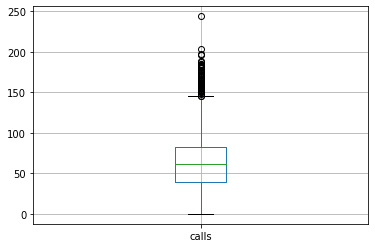

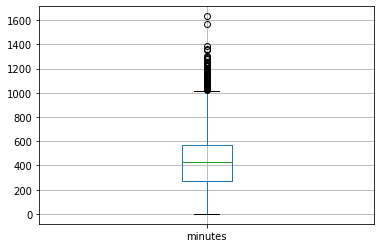

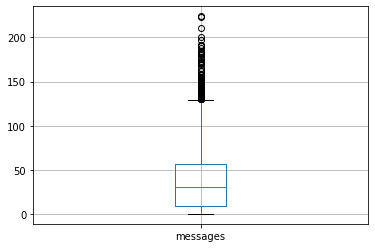

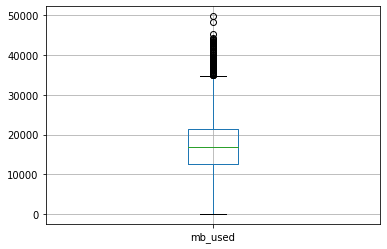

In [3]:
#Descriptive stats
display(df.describe())

cols = list(df.loc[:,'calls':'mb_used'])

for col in cols:
    df.boxplot(column = col)
    plt.show()


**Findings**: All columns contain outliers, but this is customers' data, so it's entirely possible the data is correct and the customers really did produce the numbers seen. On top of that, medians and means are close all around, so the outliers are not distorting the data.

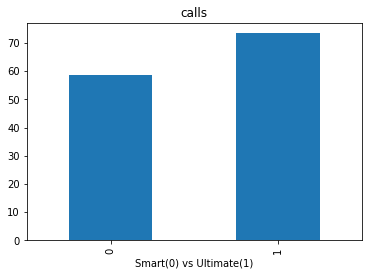

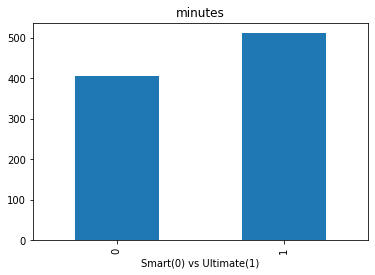

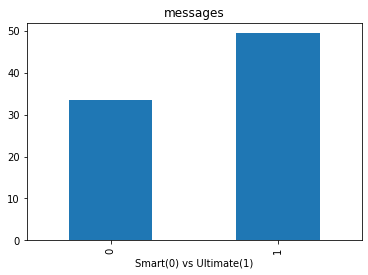

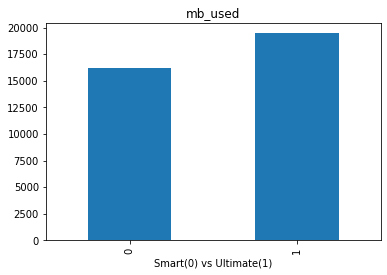

Consumer Distribution
 0    0.693528
1    0.306472
Name: is_ultimate, dtype: float64


In [4]:
#Quick look at ultra and smart plans difference in consumer usage
for col in cols:
    df.groupby('is_ultimate')[col].mean().plot(kind = 'bar')
    plt.title(col)
    plt.xlabel('Smart(0) vs Ultimate(1)')
    plt.show()
print('Consumer Distribution\n',df['is_ultimate'].value_counts()/len(df))

**Insights**: What we see here is that Ultimate users have higher means than Smart users in all offered services - they make more calls, use more minutes, send more messages and use more internet than Smart plan users. But Ultimate users are also the minority, with 70% of users having the Smart plan, and 30% the Ultimate plan.

Alright, now that we have briefly analysed our data, let's move on to building the machine learning model to recommend the plans for users.

## Model Creation

In [5]:
#Splitting the dataset between train, validation, testing
from sklearn.model_selection import train_test_split

#defining features and target
features = df.loc[:,'calls':'mb_used']
targets = df['is_ultimate']

#splitting between train (60%) and test(40%) which we will further split into validation and testing
features_train, features_test, target_train, target_test = train_test_split(features, targets, test_size=0.4, random_state=1)

#splitting the test between test and validation
features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size=0.5, random_state=1)

#checking if splits worked correctly
print(len(features_train), len(features_test), len(features_valid))

1928 643 643


Great, now we have our dataset split into 3 parts: training, validation, testing. Let's move on to models.

First, we have to choose a model. Then, we fine-tune its hyperparameters. The options we have for this classification model are the following:

- Decision Tree (low accuracy, high speed)
- Random Forest (high accuracy, low speed)
- Logistic Regression (medium accuracy, high speed)

Given the options, we would never pick the Decision Tree itself, since it is as fast as the logistic regression but offers lower accuracy. This leaves us with Random Forest and Logistic Regression models to choose. And since we are not handling to much data, we can give up some speed in exchange for more accuracy, which is what we are aiming for here - This leaves us with the **Random Forest** model.

### Random Forest Classifier Model (Chosen)

In [6]:
#modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


best_score = 0
best_est = 0

#checking best hyperparameters
for est in range(1,51):
    model = RandomForestClassifier(random_state=1, n_estimators= est)
    model.fit(features_train, target_train)
    accuracy = model.score(features_valid, target_valid)
    if accuracy > best_score:
        best_score = accuracy
        best_est = est


print('Highest Accuracy:', best_score, 'n_estimators best hyperparameter:', best_est)

Highest Accuracy: 0.8055987558320373 n_estimators best hyperparameter: 22


**Analysis**

 - We have seen that the Random Forest Classifier model has given us an 80% accuracy on the validation dataset, with the n_estimators best hyperparameter at 22, out of the 50 we tried. 
 
 
 - The final step is to test the model on the test dataset, and see if we get >75% accuracy results. If so, then we have our recommendation model to put into production for the business to recommend the correct plans for each customer based on their current plan usage.

### Model Test

In [7]:
final_model = RandomForestClassifier(random_state=1, n_estimators= best_est)
final_model.fit(features_train, target_train)

final_model_score = final_model.score(features_test, target_test)

print('Model Test Accuracy:', final_model_score)
if final_model_score > 0.75:
    print('Model Passed accuracy threshold of 75%')
else:
    print('Model Failed to pass threshold')

Model Test Accuracy: 0.7838258164852255
Model Passed accuracy threshold of 75%


### Model Results & other models

Our final model had a *78% accuracy* with the test dataset, above 50%, so it performed better than chance. Before closing the project, we'll take a glance and run the tests of the other 2 types of models, just to check how they compare.

In [8]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression(random_state=1)
model2.fit(features_train, target_train)
acc = model2.score(features_valid, target_valid)

print('Model: Logistic Regression')   
print('Logistic Regression accuracy:', acc)
print('Accuracy on test dataset:', model2.score(features_test, target_test))

Model: Logistic Regression
Logistic Regression accuracy: 0.7558320373250389
Accuracy on test dataset: 0.7200622083981337


In [9]:
from sklearn.tree import DecisionTreeClassifier

best_acc1 = 0
best_depth = 0

for depth in range(1,11):
    model3 = DecisionTreeClassifier(random_state=1, max_depth = depth)
    model3.fit(features_train, target_train)
    acc1 = model3.score(features_valid, target_valid)
    if acc1 > best_acc1:
        best_acc1 = acc1
        best_depth = depth

final_model3 = DecisionTreeClassifier(random_state=1, max_depth = best_depth)
final_model3.fit(features_train, target_train)

print('Model: Decision Tree Classifier')   
print('Highest Accuracy:', best_acc1, 'max_depth best hyperparameter:', best_depth)
print('Accuracy on test dataset:', final_model3.score(features_test, target_test))

Model: Decision Tree Classifier
Highest Accuracy: 0.7931570762052877 max_depth best hyperparameter: 6
Accuracy on test dataset: 0.7713841368584758


## Final Evaluation

**This concludes the project. Below are the key takeaways:**
1. We delivered a Model (`final_model`) that has over 75% accuracy in recommending the correct plan for the company's customers, using the RandomForestClassifier model to do so. We fine-tuned it with only one hyperparameter, the n_estimators (set at 22 for best accuracy), and this was done using the validation dataset. Finally, we tested the fine-tuned model on the test dataset for a final evaluation, which returned to us a satisfactory result (>75%).


2. LogisticRegression model had a 72% accuracy on the test set, no hyperparameters fine-tuned.


3. DecisionTreeClassifier had 77% accuracy on the test set, with one hyperparameter fine-tuned -> max_depth set at 6. Given the small difference between the RandomForest model and the DecisionTree model, one could argue the use of the DecisionTree if speed was an important component here, as results were almost the same, but DecisionTree got there much faster than the RandomForest.